<a href="https://colab.research.google.com/github/iammuhammad41/Augmented-Reality-AR-and-Virtual-Reality-VR-Assisted-Deep-Learning/blob/main/AR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
from math import sin, cos
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import cv2

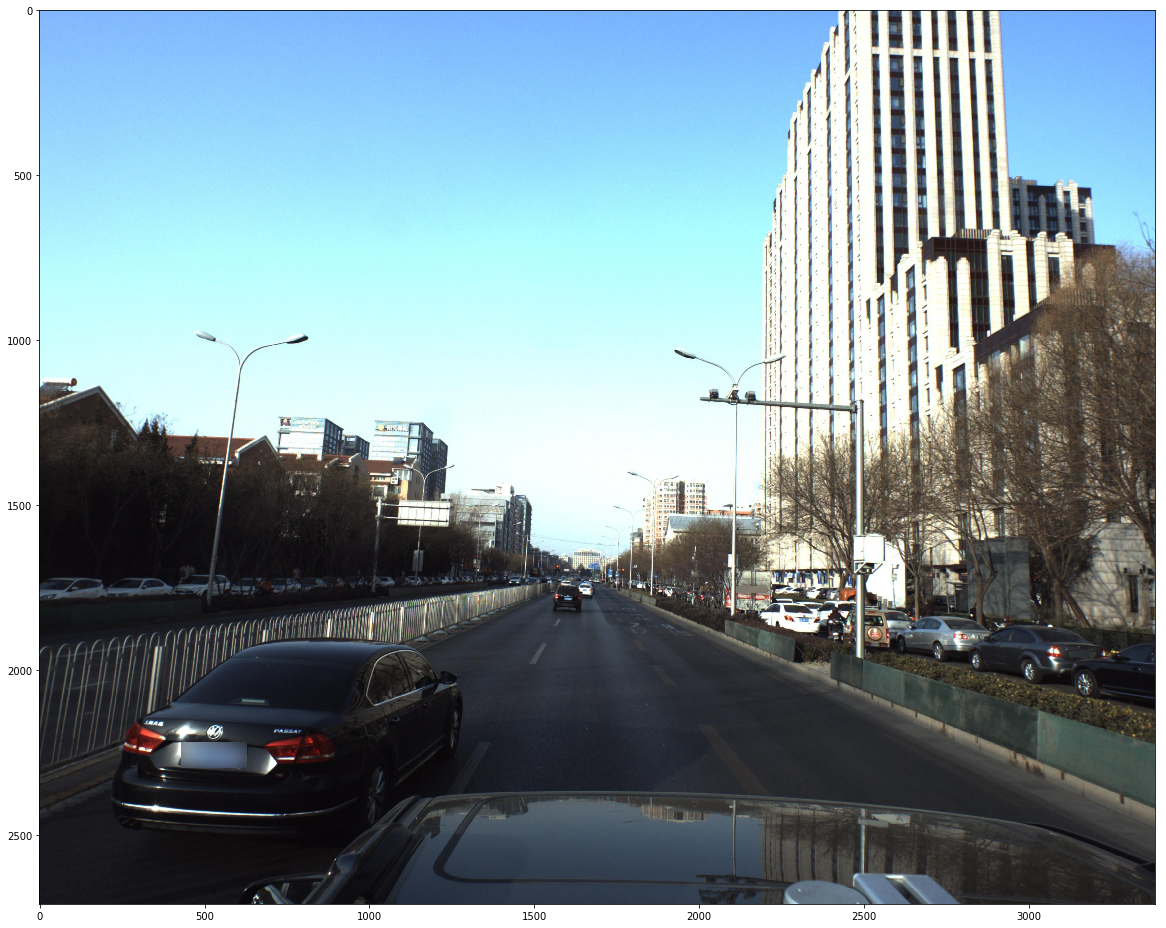

In [ ]:
# Loading an image
img_name = 'ID_0ca978538'  # 'ID_0a0980d15'
img = cv2.imread(f'../input/pku-autonomous-driving/train_images/{img_name}.jpg',cv2.COLOR_BGR2RGB)[:,:,::-1]
plt.figure(figsize=(20, 20))
plt.imshow(img);

In [ ]:
train = pd.read_csv('../input/pku-autonomous-driving/train.csv')
pred_string = train[train.ImageId == img_name].PredictionString.iloc[0]
items = pred_string.split(' ')
model_types, yaws, pitches, rolls, xs, ys, zs = [items[i::7] for i in range(7)]

In [ ]:
# k is camera instrinsic matrix
k = np.array([[2304.5479, 0,  1686.2379],
           [0, 2305.8757, 1354.9849],
           [0, 0, 1]], dtype=np.float32)

# convert euler angle to rotation matrix
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    P = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    R = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(Y, np.dot(P, R))

In [ ]:
def draw_obj(image, vertices, triangles):
    for t in triangles:
        coord = np.array([vertices[t[0]][:2], vertices[t[1]][:2], vertices[t[2]][:2]], dtype=np.int32)
#         cv2.fillConvexPoly(image, coord, (0,0,255))
        cv2.polylines(image, np.int32([coord]), 1, (0,0,255))

In [ ]:
# Load a 3D model of a car
with open('../input/pku-autonomous-driving/car_models_json/mazida-6-2015.json') as json_file:
    data = json.load(json_file)
vertices = np.array(data['vertices'])
vertices[:, 1] = -vertices[:, 1]
triangles = np.array(data['faces']) - 1

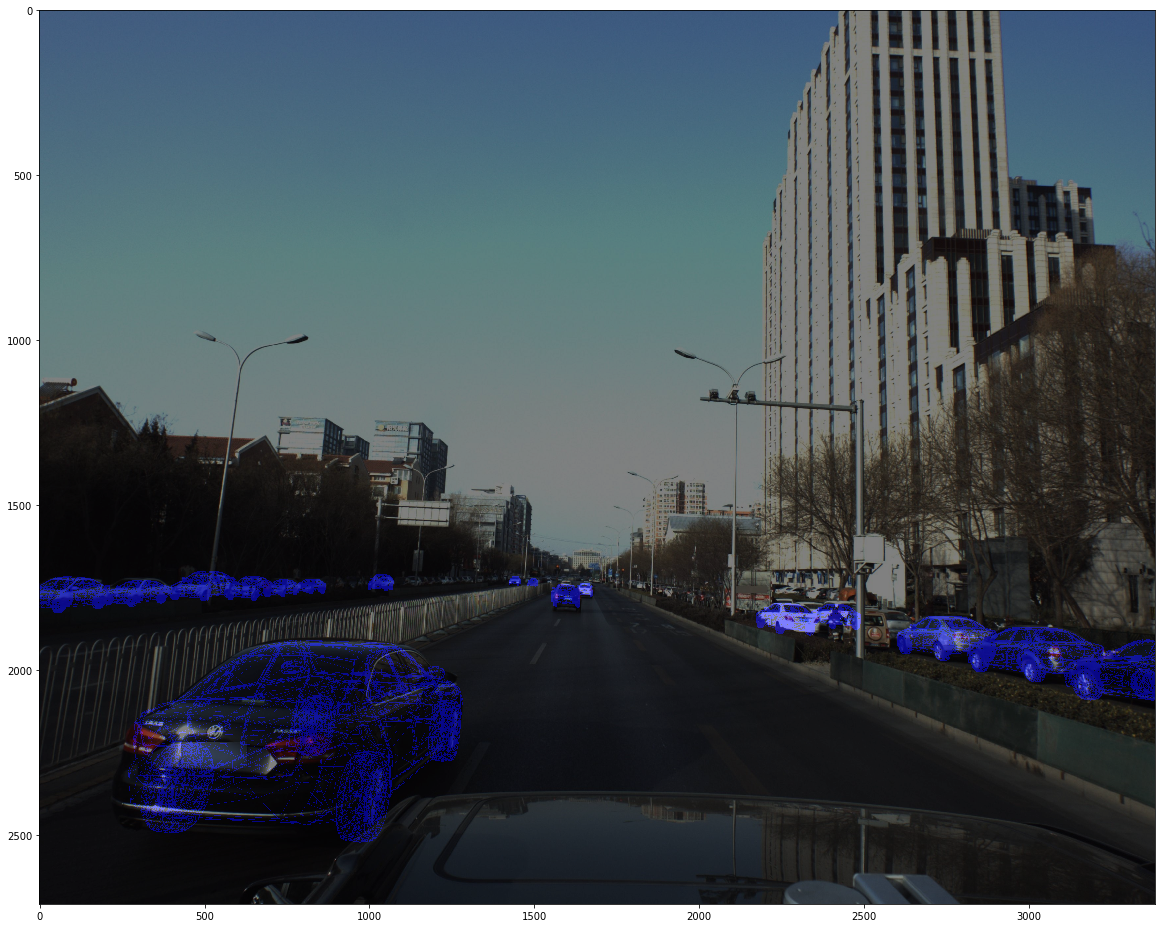

In [ ]:
overlay = np.zeros_like(img)
for yaw, pitch, roll, x, y, z in zip(yaws, pitches, rolls, xs, ys, zs):
    yaw, pitch, roll, x, y, z = [float(x) for x in [yaw, pitch, roll, x, y, z]]
    # I think the pitch and yaw should be exchanged
    yaw, pitch, roll = -pitch, -yaw, -roll
    Rt = np.eye(4)
    t = np.array([x, y, z])
    Rt[:3, 3] = t
    Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
    Rt = Rt[:3, :]
    P = np.ones((vertices.shape[0],vertices.shape[1]+1))
    P[:, :-1] = vertices
    P = P.T
    img_cor_points = np.dot(k, np.dot(Rt, P))
    img_cor_points = img_cor_points.T
    img_cor_points[:, 0] /= img_cor_points[:, 2]
    img_cor_points[:, 1] /= img_cor_points[:, 2]
    draw_obj(overlay, img_cor_points, triangles)

alpha = .5
img = np.array(img)
cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, img)
plt.figure(figsize=(20,20))
plt.imshow(img);